# ** PROJET 7 - Classifiez automatiquement des biens de consommation **

___

##### SOMMAIRE DU NOTEBOOK MODELLING & STREAMLIT  2/2
  
  **IV. MODELLING**    
  _1. Dummy Classifier    
  _2. Regression Logistic  
  _3. Random Forest  
  _4. XGBoost  
  _5. Light GBM
    
  **V. STREAMLIT**  
   _1. Sample  
   _2. Model joblib


___

##### IMPORTATION DES LIBRAIRIES

In [1]:
# data
import pandas as pd 
import numpy as np
import sys
from sys import path
import os
import joblib


# vizualisation
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 


# modelling
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.preprocessing import MinMaxScaler


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, auc
from sklearn.metrics import fbeta_score, make_scorer


# classifiers
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier


# over/Undersampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import imblearn
from imblearn.over_sampling import SMOTE


# importance features
import shap
import time


from P7_functions import *

# Others
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print("Setup complete.")

Setup complete.


##### IMPORTATION DES DONNEES

In [2]:
PATH="./P7_DATA/cleaned/"
filename ="df.csv"

df = pd.read_csv(PATH+filename)

In [3]:
df.shape

(307507, 508)

In [4]:
df.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,100002.0,1.0,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19.0
1,100003.0,0.0,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25.0
2,100004.0,0.0,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3.0
3,100006.0,0.0,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,...,62947.088438,1007153.415,2482.920,691786.890,62947.088438,1007153.415,-12.0,-271.625000,-4346.0,16.0
4,100007.0,0.0,0.0,0.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,...,12666.444545,835985.340,0.180,22678.785,12214.060227,806127.975,-14.0,-1032.242424,-68128.0,66.0


In [5]:
# répartition de la target
df['TARGET'].value_counts(normalize = True).round(2)

0.0    0.92
1.0    0.08
Name: TARGET, dtype: float64

In [6]:
feature_to_drop = ['SK_ID_CURR']
df = df.drop(feature_to_drop, axis=1)
df.head()

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,1.0,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19.0
1,0.0,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25.0
2,0.0,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3.0
3,0.0,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,...,62947.088438,1007153.415,2482.920,691786.890,62947.088438,1007153.415,-12.0,-271.625000,-4346.0,16.0
4,0.0,0.0,0.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,...,12666.444545,835985.340,0.180,22678.785,12214.060227,806127.975,-14.0,-1032.242424,-68128.0,66.0


In [7]:
# Etape importante pour le bon fonctionnement de Shap
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [8]:
y = df['TARGET']
X = df.drop('TARGET', axis=1)

display(X.shape)
display(y.shape)

(307507, 506)

(307507,)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(246005, 506)

(61502, 506)

(246005,)

(61502,)

In [10]:
pd.Series(y_test).value_counts(normalize=True).round(2)

0.0    0.92
1.0    0.08
Name: TARGET, dtype: float64

___

**SAMPLE POUR MODELLING (50000 individus)**

In [11]:
df_sample = df.sample(n=50000, random_state=22)
df_sample.head()

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
254582,0.0,0.0,1.0,1.0,0.0,202500.0,585000.0,16762.5,585000.0,0.030755,...,6485.047500,38910.285,187.110,19058.760,5161.612500,30969.675,-2391.0,-2421.500000,-14529.0,6.0
69186,0.0,1.0,0.0,0.0,0.0,94500.0,52128.0,5472.0,45000.0,0.002042,...,45346.822660,2131300.665,18.045,447975.765,38159.265638,1793485.485,-253.0,-809.808511,-38061.0,47.0
207296,0.0,1.0,0.0,0.0,0.0,135000.0,495000.0,25402.5,495000.0,0.028663,...,6411.729512,262880.910,9.000,9268.200,5571.801220,228443.850,-33.0,-794.073171,-32557.0,41.0
287769,1.0,1.0,1.0,1.0,0.0,247500.0,935640.0,88834.5,900000.0,0.072508,...,5781.935593,341134.200,133.380,12558.915,5631.930763,332283.915,-31.0,-617.762712,-36448.0,59.0
212139,0.0,0.0,0.0,0.0,0.0,90000.0,158301.0,16348.5,148500.0,0.011657,...,32997.170455,725937.750,6.300,142913.565,30608.468182,673386.300,-446.0,-779.772727,-17155.0,22.0


In [12]:
# Répartition de la target
df_sample['TARGET'].value_counts(normalize = True).round(2)

0.0    0.92
1.0    0.08
Name: TARGET, dtype: float64

In [13]:
y_sample = df_sample['TARGET']
X_sample = df_sample.drop('TARGET', axis=1)

display(X_sample.shape)
display(y_sample.shape)

(50000, 506)

(50000,)

In [14]:
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample, y_sample, test_size=0.2, random_state=22)

display(X_train_sample.shape)
display(X_test_sample.shape)
display(y_train_sample.shape)
display(y_test_sample.shape)

(40000, 506)

(10000, 506)

(40000,)

(10000,)

In [15]:
# Vérification de la répartition de la target après le split
pd.Series(y_test_sample).value_counts(normalize=True).round(2)

0.0    0.92
1.0    0.08
Name: TARGET, dtype: float64

___

# III. MODELLING

In [16]:
def score(estimator):
    """compute and print train score and test score"""
        
    tr_score = estimator.score(X_train_sample, y_train_sample).round(4) # accuracy score
    te_score = estimator.score(X_test_sample, y_test_sample).round(4) 
    
    print(type(estimator).__name__)
    print(f"score train: {tr_score}, score test: {te_score}, time: {fit_time}")

In [17]:
def confusion(y_test, y_pred) :
    """display a fancy confusion matrix"""
    
    mat = confusion_matrix(y_test, y_pred)
    mat = pd.DataFrame(mat)
    mat.columns = [f"pred_{i}" for i in mat.columns]
    mat.index= [f"test_{i}" for i in mat.index]
    
    
    plt.figure(figsize=(4, 4))

    ax= plt.subplot()
    sns.heatmap(mat, annot=True, fmt="d", annot_kws={"size": 10}, ax=ax, cmap='RdPu');
    plt.title('Confusion matrix', fontsize = 10, fontweight = 'bold')
    
    return plt.show()

In [18]:
def courbe(model) :
    """display a roc auc"""
    
    y_pred_proba = model.predict_proba(X_test_sample)[:,1]
    [fpr, tpr, thr] = roc_curve(y_test_sample, y_pred_proba)
    auc = roc_auc_score(y_test_sample, y_pred_proba) # aire AUC_ROC
    plt.plot(fpr,tpr, label = 'ROC curve (area = %0.3f)' % auc, color='violet', lw=2)
    plt.plot([0,1], [0, 1], linestyle = '--', label = 'Baseline performance')
    plt.xlabel('1 - specificite', fontsize=14)
    plt.ylabel('Sensibilite', fontsize=14)
    plt.legend(loc=4)
    
    return plt.show()

# https://openclassrooms.com/fr/courses/4297211-evaluez-les-performances-dun-modele-de-machine-learning/4308261-evaluez-un-algorithme-de-classification-qui-retourne-des-scores


## III. 1. DUMMY CLASSIFIER

https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html  
https://www.youtube.com/watch?v=sGI2QZHOhkM&list=WL&index=2

In [19]:
# Base de comparaison avec Dummy, qui retourne la valeur moyenne des étiquettes
dummy_class = DummyClassifier(strategy="stratified", random_state=22)

start_time = time.time()

# Entrainement
dummy_class.fit(X_train_sample, y_train_sample)

fit_time = time.time() - start_time

# prédiction sur le jeu de test
y_predict_dummy = dummy_class.predict(X_test_sample)

In [20]:
score(dummy_class)

DummyClassifier
score train: 0.8542, score test: 0.8549, time: 0.00556635856628418


In [21]:
# Répartition de la target
pd.Series(y_predict_dummy).value_counts(normalize=True)

0.0    0.9201
1.0    0.0799
dtype: float64

**Matrice de confusion & Courbe AUC ROC**

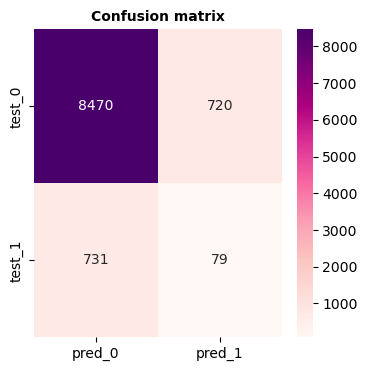

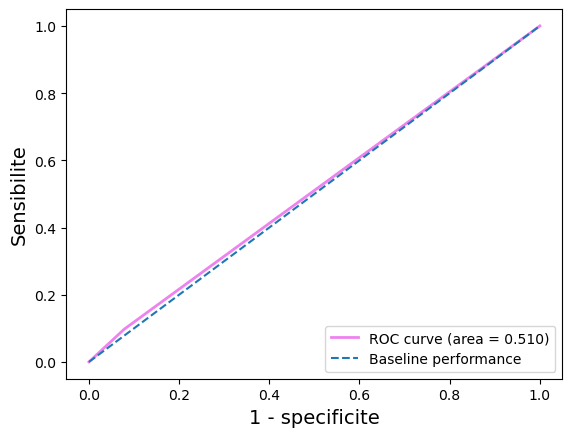

In [22]:
confusion(y_test_sample, y_predict_dummy )
courbe(dummy_class)

___

## III. 2. REGRESSION LOGISTIQUE

https://www.youtube.com/watch?v=gBG9CPwafO4&list=WL&index=1  
https://www.cours-gratuit.com/tutoriel-python/tutoriel-python-matriser-la-rgression-logistique-avec-scikit-learn

In [23]:
lr = LogisticRegression(random_state=22)
print ('Paramètres habituellement utilisés:')
lr.get_params()

Paramètres habituellement utilisés:


{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 22,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [24]:
# define model
model = LogisticRegression(random_state=22)

# define scaler
scaler = MinMaxScaler(feature_range = (0, 1))

# define pipeline
steps = [('scaler', scaler), ('model', model)]
pipeline = Pipeline(steps=steps)


# Parameter grid
parameters = {  'model__C': [0.1, 1, 10],
                #'model__penalty':['l1','l2'],
                #'model__solver':['newton-cg','lbfgs','saga']
         }

# define cross-validation procedure
grid_lr = GridSearchCV(estimator = pipeline, 
                              param_grid = parameters,
                              cv = 4, 
                              verbose = 3,
                              n_jobs = -1, 
                              scoring = 'roc_auc',
                              error_score="raise",
                              refit=True)

In [25]:
start_time = time.time()

grid_lr.fit(X_train_sample, y_train_sample)

fit_time = time.time() - start_time

Fitting 4 folds for each of 3 candidates, totalling 12 fits


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [26]:
# Predict sur le meilleur modèle
best_grid_lr = grid_lr.best_estimator_

y_pred_lr = best_grid_lr.predict(X_test_sample)

In [27]:
grid_lr.best_score_

0.7473513406416632

In [28]:
resultize(grid_lr).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,params,mean_test_score,std_test_score,rank_test_score
0,12.582030,1.190769,0.256405,0.011474,0.1,{'model__C': 0.1},0.747351,0.009010,1
1,14.511314,0.343114,0.206924,0.010671,1,{'model__C': 1},0.745671,0.006932,2
2,8.213633,0.529480,0.120006,0.022872,10,{'model__C': 10},0.742869,0.006032,3


**Matrice de confusion & Courbe AUC ROC**

Pipeline
score train: 0.9206, score test: 0.9186, time: 32.09750199317932


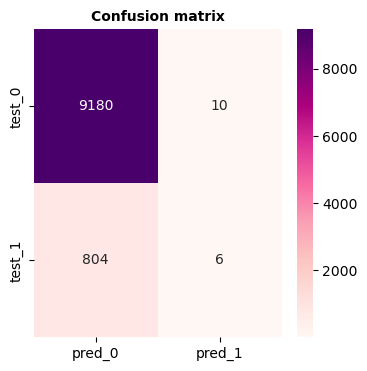

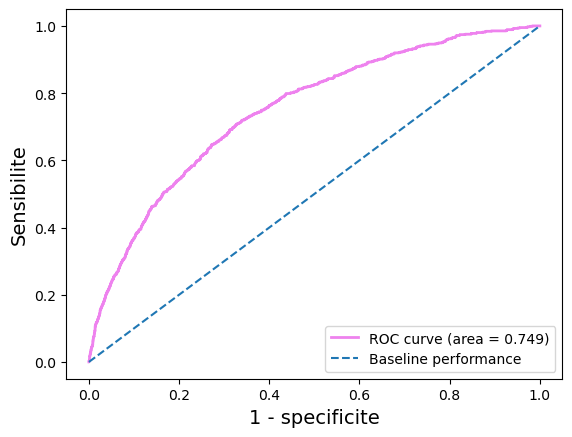

In [29]:
score(best_grid_lr)
confusion(y_test_sample,y_pred_lr)
courbe(best_grid_lr)

https://machinelearningmastery.com/calculate-feature-importance-with-python/

Feature: 0, Score: -0.36300
Feature: 1, Score: -0.23785
Feature: 2, Score: -0.07599
Feature: 3, Score: 0.13197
Feature: 4, Score: 0.04107
Feature: 5, Score: 0.02801
Feature: 6, Score: 0.43794
Feature: 7, Score: -0.51786
Feature: 8, Score: 0.13763
Feature: 9, Score: 0.27076
Feature: 10, Score: 0.20367
Feature: 11, Score: 0.18919
Feature: 12, Score: 0.18945
Feature: 13, Score: 0.00000
Feature: 14, Score: -0.09498
Feature: 15, Score: 0.17338
Feature: 16, Score: -0.01308
Feature: 17, Score: -0.10358
Feature: 18, Score: -0.09027
Feature: 19, Score: 0.11715
Feature: 20, Score: 0.04147
Feature: 21, Score: 0.18272
Feature: 22, Score: -0.05047
Feature: 23, Score: 0.01673
Feature: 24, Score: -0.12845
Feature: 25, Score: 0.02094
Feature: 26, Score: 0.16974
Feature: 27, Score: 0.01340
Feature: 28, Score: 0.03442
Feature: 29, Score: -1.72965
Feature: 30, Score: -1.89878
Feature: 31, Score: 0.10348
Feature: 32, Score: 0.47512
Feature: 33, Score: 0.11330
Feature: 34, Score: 0.27103
Feature: 35, Score

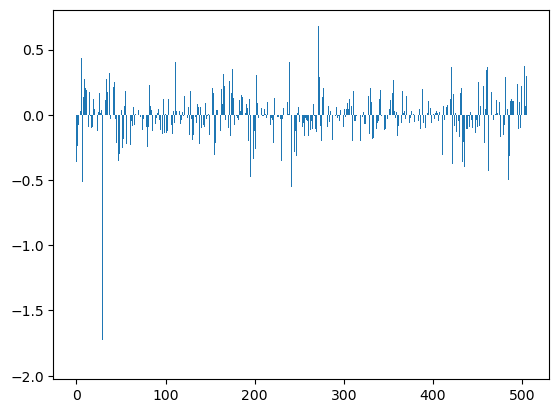

In [30]:
# get importance
importance = grid_lr.best_estimator_.named_steps['model'].coef_[0]

# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

___

## III. 3. RANDOM FOREST CLASSIFIER

In [31]:
rfc = RandomForestClassifier(random_state=22)

In [32]:
print ('Paramètres habituellement utilisés:')
rfc.get_params()

Paramètres habituellement utilisés:


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 22,
 'verbose': 0,
 'warm_start': False}

In [33]:
# define model
model = RandomForestClassifier(random_state=22)

# define scaler
scaler = MinMaxScaler(feature_range = (0, 1))

# define pipeline
steps = [('scaler', scaler), ('model', model)]
pipeline = Pipeline(steps=steps)


# Parameter grid
parameters = {  'model__n_estimators': [500],
                'model__max_depth': range(5, 10, 1),          
                'model__min_samples_leaf': [1, 5, 10]
             }

# define cross-validation procedure
grid_rfc = GridSearchCV(estimator = pipeline, 
                              param_grid = parameters,
                              cv = 4, 
                              verbose = 3,
                              n_jobs = -1, 
                              scoring = 'roc_auc',
                              error_score="raise",
                              refit=True)

In [34]:
grid_rfc.fit(X_train_sample, y_train_sample)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


GridSearchCV(cv=4, error_score='raise',
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('model',
                                        RandomForestClassifier(random_state=22))]),
             n_jobs=-1,
             param_grid={'model__max_depth': range(5, 10),
                         'model__min_samples_leaf': [1, 5, 10],
                         'model__n_estimators': [500]},
             scoring='roc_auc', verbose=3)

In [35]:
# Predict sur le meilleur modèle
best_grid_rfc = grid_rfc.best_estimator_

y_pred_rfc = best_grid_rfc.predict(X_test_sample)

In [36]:
grid_rfc.best_score_

0.7325533077638037

In [37]:
resultize(grid_rfc).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__min_samples_leaf,param_model__n_estimators,params,mean_test_score,std_test_score,rank_test_score
14,127.838583,0.466192,1.657183,0.254157,9,10,500,"{'model__max_depth': 9, 'model__min_samples_le...",0.732553,0.010113,1
11,127.050293,0.989555,1.710096,0.080519,8,10,500,"{'model__max_depth': 8, 'model__min_samples_le...",0.732357,0.010122,2
13,139.185651,0.982447,1.567504,0.062670,9,5,500,"{'model__max_depth': 9, 'model__min_samples_le...",0.732157,0.010157,3
12,143.196812,0.587488,1.819330,0.051412,9,1,500,"{'model__max_depth': 9, 'model__min_samples_le...",0.731811,0.010078,4
10,122.181662,1.117713,1.902369,0.275816,8,5,500,"{'model__max_depth': 8, 'model__min_samples_le...",0.731610,0.010658,5
9,122.720023,0.236720,1.599352,0.026750,8,1,500,"{'model__max_depth': 8, 'model__min_samples_le...",0.731383,0.009942,6
7,110.848050,0.789936,1.395363,0.050545,7,5,500,"{'model__max_depth': 7, 'model__min_samples_le...",0.731051,0.010129,7
5,93.798235,0.543920,1.473320,0.155911,6,10,500,"{'model__max_depth': 6, 'model__min_samples_le...",0.730642,0.011452,8
8,106.232972,0.353684,1.513020,0.039460,7,10,500,"{'model__max_depth': 7, 'model__min_samples_le...",0.730300,0.010930,9
4,96.304441,1.019851,1.352846,0.003306,6,5,500,"{'model__max_depth': 6, 'model__min_samples_le...",0.730049,0.011176,10


**Matrice de confusion & Courbe AUC ROC**

Pipeline
score train: 0.9202, score test: 0.919, time: 32.09750199317932


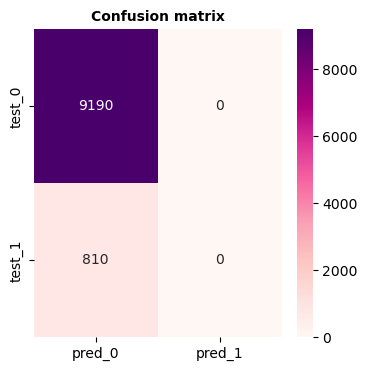

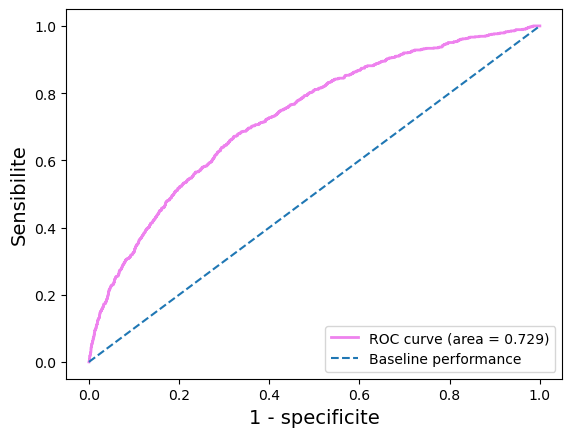

In [38]:
score(best_grid_rfc)
confusion(y_test_sample,y_pred_rfc)
courbe(best_grid_rfc)

___

## III. 4. XGBOOST

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [39]:
model_boost = GradientBoostingClassifier()

In [40]:
print ('Paramètres habituellement utilisés:')
model_boost.get_params()

Paramètres habituellement utilisés:


{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [41]:
# define model
model = GradientBoostingClassifier(random_state=22)

# define scaler
scaler = MinMaxScaler(feature_range = (0, 1))

# define pipeline
steps = [('scaler', scaler), ('model', model)]
pipeline = Pipeline(steps=steps)


# Parameter grid
parameters = {  'model__learning_rate' : [0.01, 0.05, 0.10, 0.50, 1]
             }

# define cross-validation procedure
grid_boost = GridSearchCV(estimator = pipeline, 
                              param_grid = parameters,
                              cv = 4, 
                              verbose = 3,
                              n_jobs = -1, 
                              scoring = 'roc_auc',
                              error_score="raise",
                              refit=True)

In [42]:
grid_boost.fit(X_train_sample, y_train_sample)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


GridSearchCV(cv=4, error_score='raise',
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('model',
                                        GradientBoostingClassifier(random_state=22))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1, 0.5, 1]},
             scoring='roc_auc', verbose=3)

In [43]:
# Predict sur le meilleur modèle
best_grid_boost = grid_boost.best_estimator_

y_pred_boost = best_grid_boost.predict(X_test_sample)

In [44]:
grid_boost.best_score_

0.7535455311736439

In [45]:
resultize(grid_boost).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,params,mean_test_score,std_test_score,rank_test_score
2,296.344787,2.569025,0.244674,0.015046,0.1,{'model__learning_rate': 0.1},0.753546,0.007273,1
1,286.341104,0.819177,0.298592,0.015122,0.05,{'model__learning_rate': 0.05},0.746717,0.006639,2
3,293.959945,0.996377,0.248576,0.019585,0.5,{'model__learning_rate': 0.5},0.735327,0.008485,3
0,286.978241,0.799167,0.287600,0.039591,0.01,{'model__learning_rate': 0.01},0.715145,0.004902,4
4,224.319002,0.584092,0.173477,0.010823,1,{'model__learning_rate': 1},0.697465,0.005608,5


**Matrice de confusion & Courbe AUC ROC**

Pipeline
score train: 0.9232, score test: 0.9189, time: 32.09750199317932


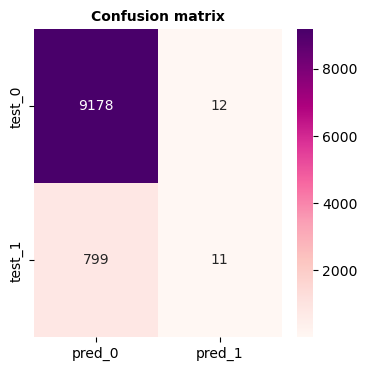

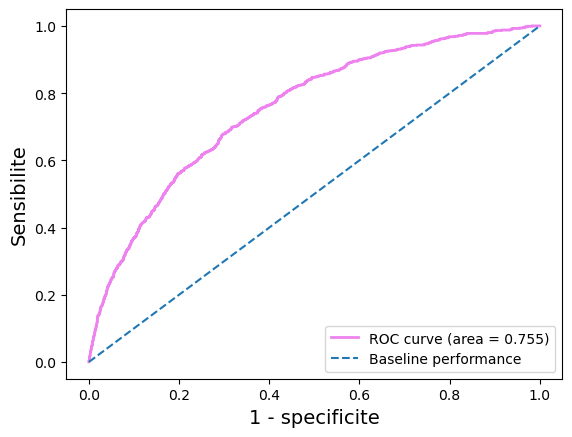

In [46]:
score(best_grid_boost)
confusion(y_test_sample,y_pred_boost)
courbe(best_grid_boost)

___

## III. 5. LIGHT GBM

In [47]:
clf = lgb.LGBMClassifier()

In [48]:
print ('Paramètres habituellement utilisés:')
clf.get_params()

Paramètres habituellement utilisés:


{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [49]:
# define model
model = lgb.LGBMClassifier(random_state=22)

# define scaler
scaler = MinMaxScaler(feature_range = (0, 1))

# define pipeline
steps = [('scaler', scaler), ('model', model)]
pipeline = Pipeline(steps=steps)


# Parameter grid
parameters = {  'model__n_estimators': [1000],
                'model__learning_rate': [0.01, 0.05, 0.10, 0.50]
            }

# define cross-validation procedure
grid_lgmc = GridSearchCV(estimator = pipeline, 
                              param_grid = parameters,
                              cv = 4, 
                              verbose = 3,
                              n_jobs = -1, 
                              scoring = 'roc_auc',
                              error_score="raise",
                              refit=True)

In [50]:
grid_lgmc.fit(X_train_sample, y_train_sample)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


GridSearchCV(cv=4, error_score='raise',
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('model',
                                        LGBMClassifier(random_state=22))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1, 0.5],
                         'model__n_estimators': [1000]},
             scoring='roc_auc', verbose=3)

In [51]:
# Predict sur le meilleur modèle
best_grid_light = grid_lgmc.best_estimator_

y_pred_light = best_grid_light.predict(X_test_sample)

In [52]:
grid_lgmc.best_params_

{'model__learning_rate': 0.01, 'model__n_estimators': 1000}

In [53]:
grid_lgmc.best_score_

0.7572309806686583

In [54]:
resultize(grid_lgmc).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__n_estimators,params,mean_test_score,std_test_score,rank_test_score
0,94.421933,3.630250,2.236349,0.104225,0.01,1000,"{'model__learning_rate': 0.01, 'model__n_estim...",0.757231,0.009712,1
1,85.314783,2.202350,2.027749,0.065038,0.05,1000,"{'model__learning_rate': 0.05, 'model__n_estim...",0.741838,0.008665,2
2,85.724852,0.779746,1.724170,0.018205,0.1,1000,"{'model__learning_rate': 0.1, 'model__n_estima...",0.728116,0.007075,3
3,85.830203,0.904385,1.584441,0.074504,0.5,1000,"{'model__learning_rate': 0.5, 'model__n_estima...",0.711697,0.008444,4


**Matrice de confusion & Courbe AUC ROC**

In [55]:
score(best_grid_light)


Pipeline
score train: 0.9316, score test: 0.9188, time: 32.09750199317932


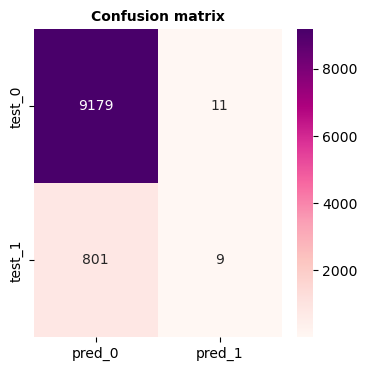

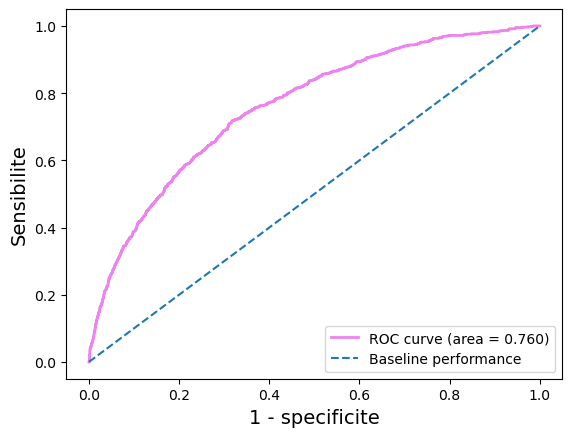

In [57]:
confusion(y_test_sample,y_pred_light)
courbe(best_grid_light)

___

### LIGHT LGBM avec SMOTE

In [58]:
# define model
model = lgb.LGBMClassifier(random_state=22)

# define scaler
scaler = MinMaxScaler(feature_range = (0, 1))

# define pipeline
oversample = SMOTE(k_neighbors=3, sampling_strategy=0.3)
undersample = RandomUnderSampler(sampling_strategy=0.5)
steps = [('scaler', scaler), ('over', oversample), ('under', undersample), ('model', model)]
pipeline = Pipeline(steps=steps)


# Parameter grid
parameters = {  'model__n_estimators': [1000],
                'model__learning_rate': [0.01, 0.05, 0.10, 0.50]
            }

ftwo_scorer = make_scorer(fbeta_score, beta=2)

# define cross-validation procedure
grid_lgmc_smote = GridSearchCV(estimator = pipeline, 
                              param_grid = parameters,
                              cv = 4, 
                              verbose = 3,
                              n_jobs = -1, 
                              scoring = ftwo_scorer,
                              error_score="raise",
                              refit=True)

In [59]:
grid_lgmc_smote.fit(X_train, y_train)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


GridSearchCV(cv=4, error_score='raise',
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('over',
                                        SMOTE(k_neighbors=3,
                                              sampling_strategy=0.3)),
                                       ('under',
                                        RandomUnderSampler(sampling_strategy=0.5)),
                                       ('model',
                                        LGBMClassifier(random_state=22))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1, 0.5],
                         'model__n_estimators': [1000]},
             scoring=make_scorer(fbeta_score, beta=2), verbose=3)

In [60]:
# Predict sur le meilleur modèle
best_grid_light_smote = grid_lgmc_smote.best_estimator_

In [61]:
best_grid_light_smote

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('over', SMOTE(k_neighbors=3, sampling_strategy=0.3)),
                ('under', RandomUnderSampler(sampling_strategy=0.5)),
                ('model',
                 LGBMClassifier(learning_rate=0.5, n_estimators=1000,
                                random_state=22))])

In [62]:
y_pred_light_smote = best_grid_light_smote.predict(X_test)

In [63]:
grid_lgmc_smote.best_params_

{'model__learning_rate': 0.5, 'model__n_estimators': 1000}

In [64]:
# fBeta

grid_lgmc_smote.best_score_

0.17278953902983535

In [65]:
resultize(grid_lgmc_smote).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__n_estimators,params,mean_test_score,std_test_score,rank_test_score
3,309.286605,3.643419,5.488709,0.550509,0.5,1000,"{'model__learning_rate': 0.5, 'model__n_estima...",0.172790,0.005846,1
2,377.462327,6.044252,10.917154,0.286987,0.1,1000,"{'model__learning_rate': 0.1, 'model__n_estima...",0.142321,0.003175,2
1,454.925768,15.636359,15.248779,1.712411,0.05,1000,"{'model__learning_rate': 0.05, 'model__n_estim...",0.133114,0.001190,3
0,666.628366,3.749702,25.277867,0.899864,0.01,1000,"{'model__learning_rate': 0.01, 'model__n_estim...",0.095222,0.003585,4


**Matrice de confusion & Courbe AUC ROC**

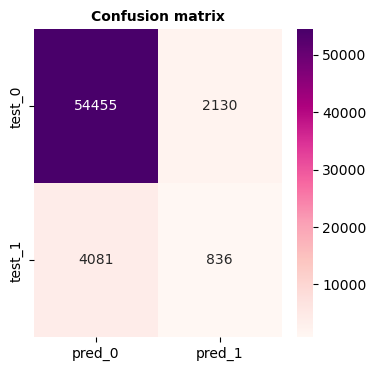

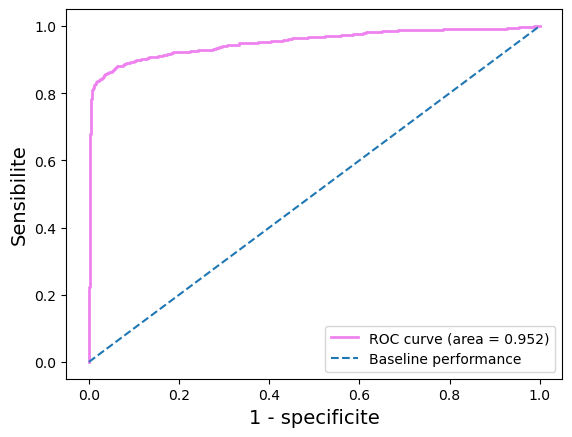

In [66]:
confusion(y_test,y_pred_light_smote)
courbe(best_grid_light_smote)

In [67]:
coefficients_light = (grid_lgmc_smote.best_estimator_._final_estimator.feature_importances_)

**Features importance**

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


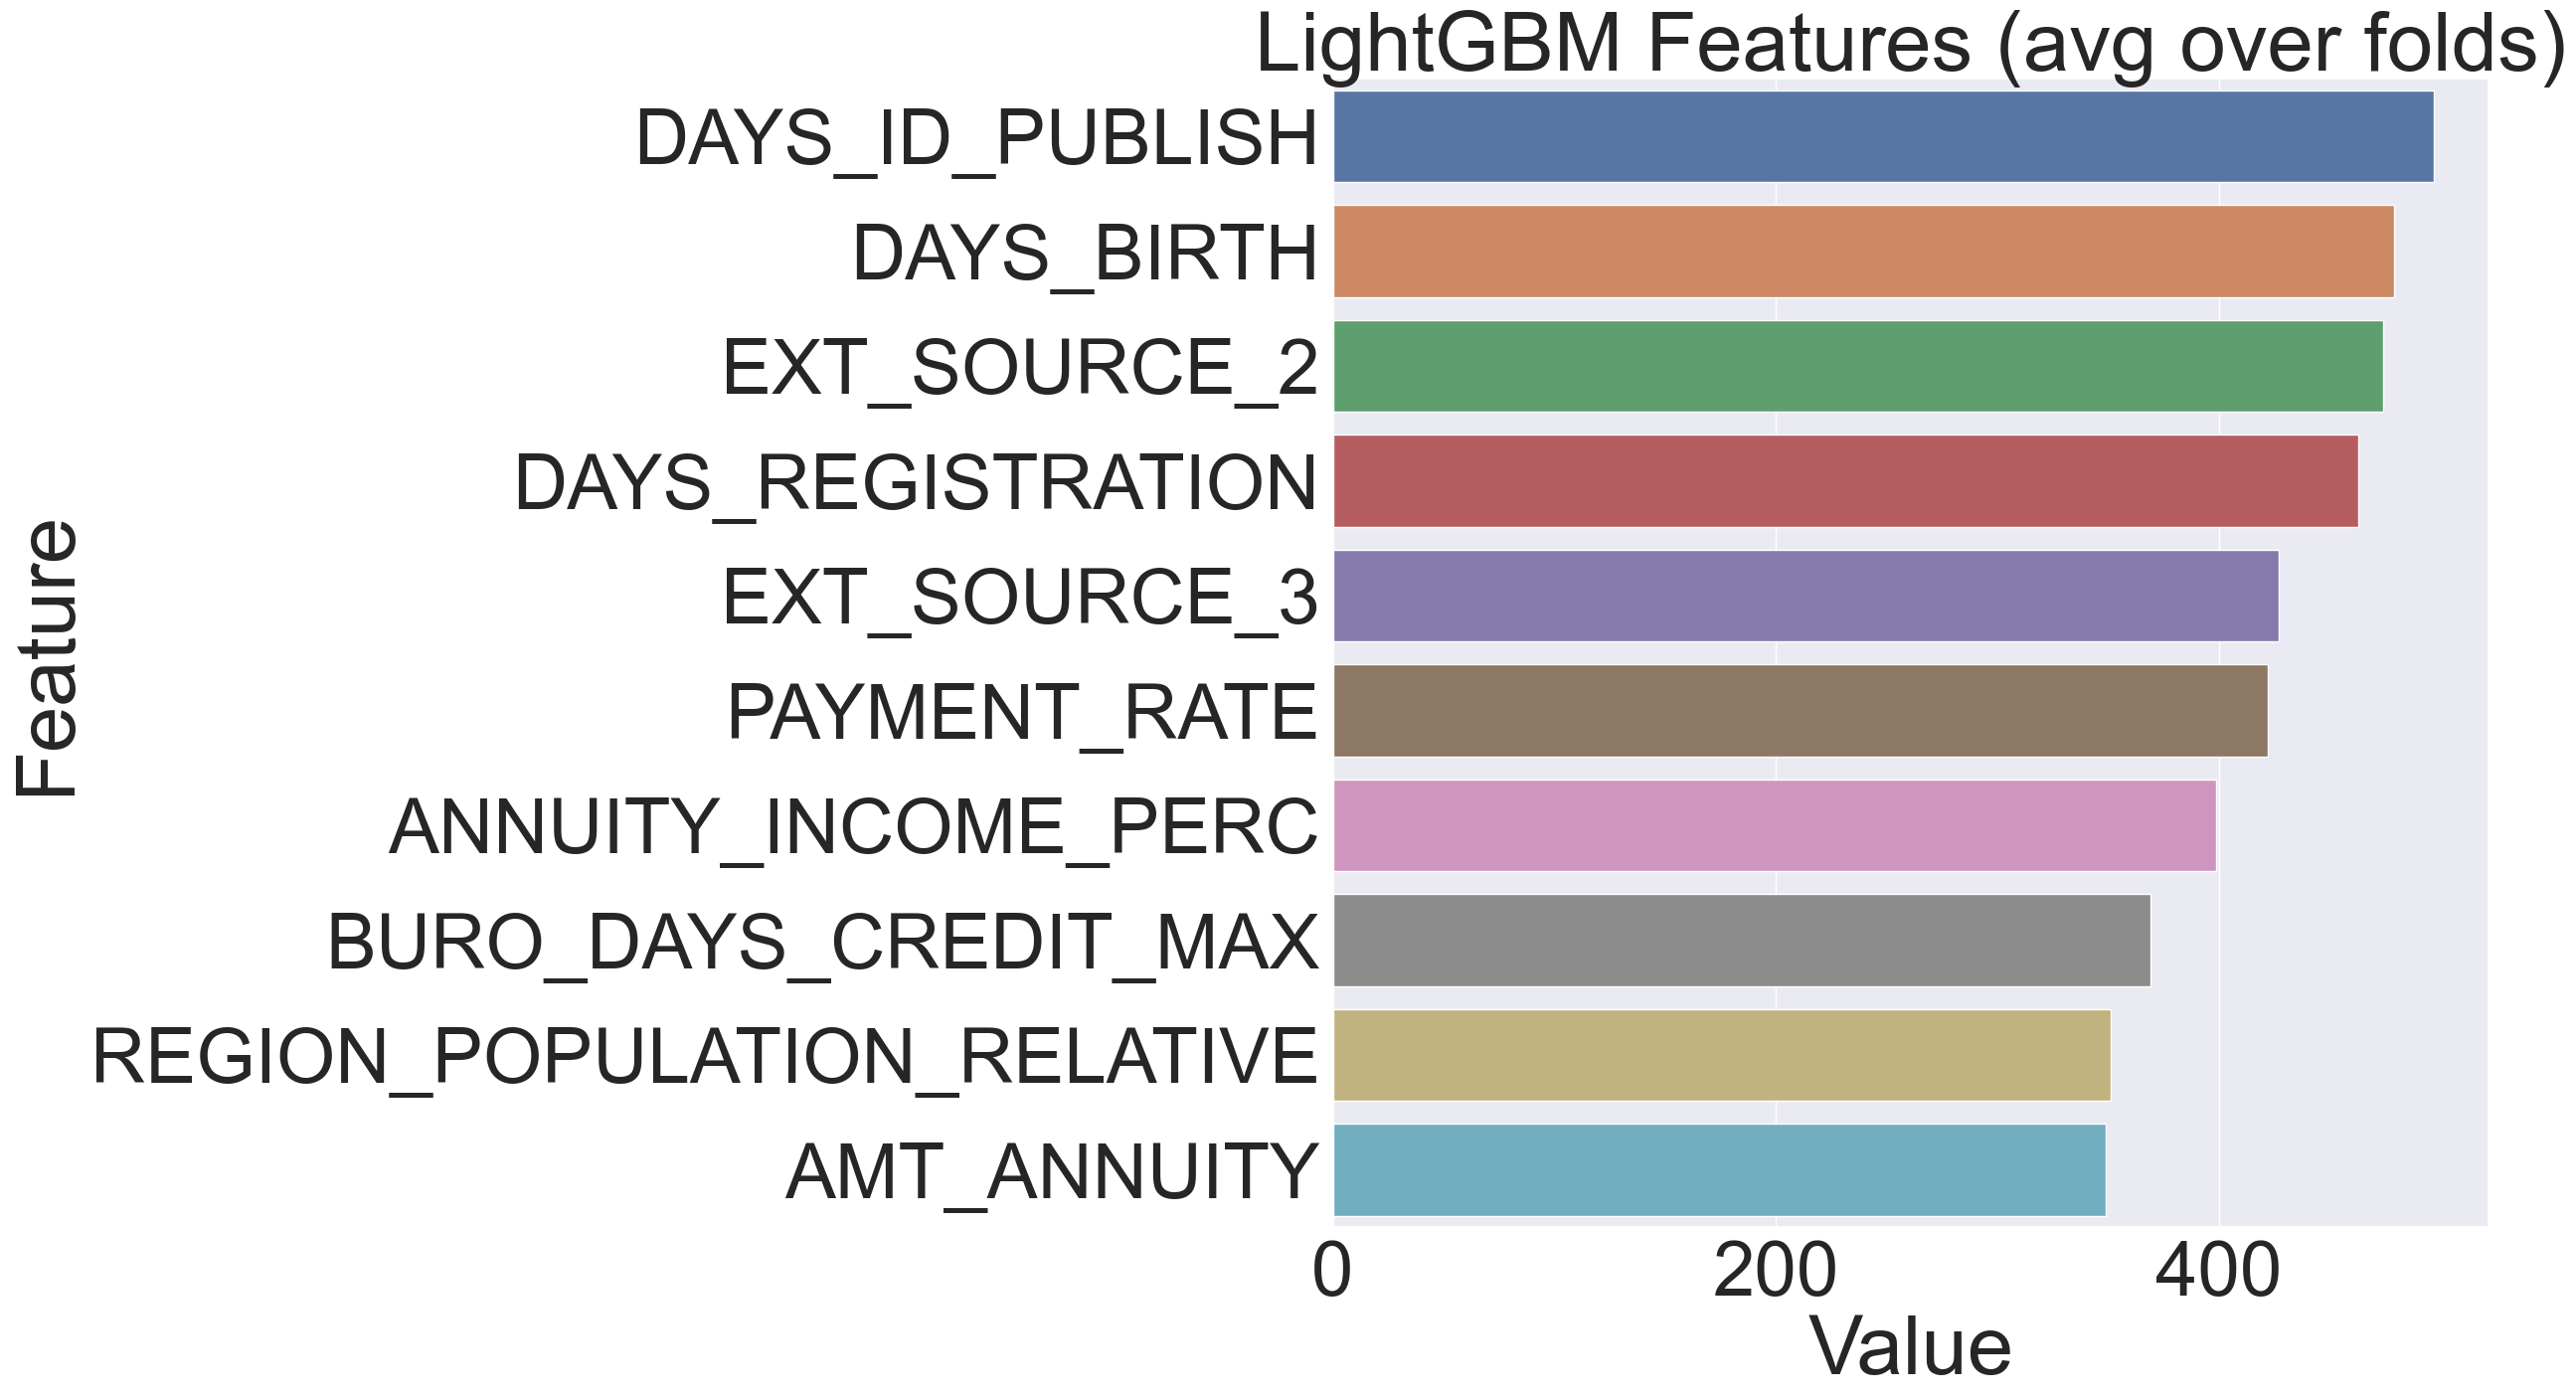

In [68]:
feature_imp = pd.DataFrame({'Value':coefficients_light,'Feature':X_test.columns})

plt.figure(figsize=(15,15))
sns.set(font_scale = 5)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:10])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

___

### SHAPE avec LIGHT GBM

In [69]:
shap.initjs()

In [70]:
shap_model = lgb.LGBMClassifier(learning_rate= 0.5, n_estimators= 1000, random_state=22) # Modèle optimisé
shap_model.fit(X, y)

LGBMClassifier(learning_rate=0.5, n_estimators=1000, random_state=22)

In [71]:
explainer = shap.TreeExplainer(shap_model)
shap_values = explainer.shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


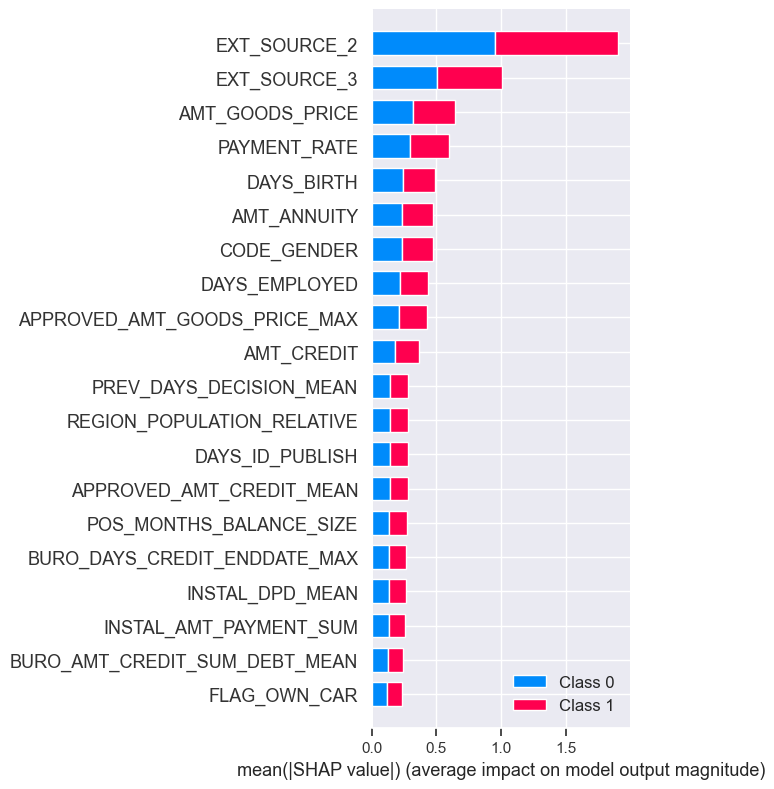

In [72]:
shap.summary_plot(shap_values, X_test)

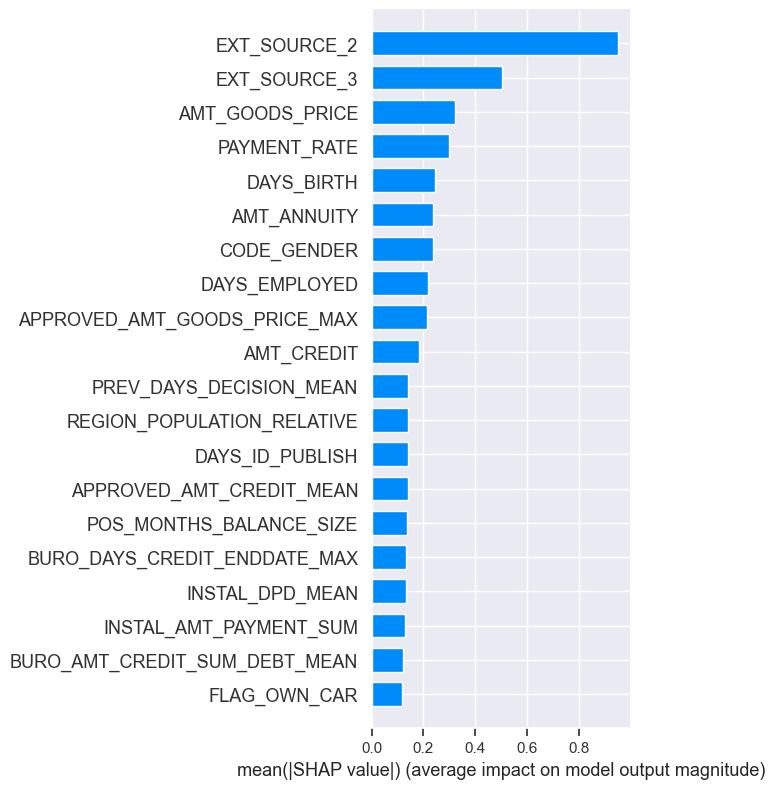

In [73]:
shap.summary_plot(shap_values[1], X_test, plot_type="bar")

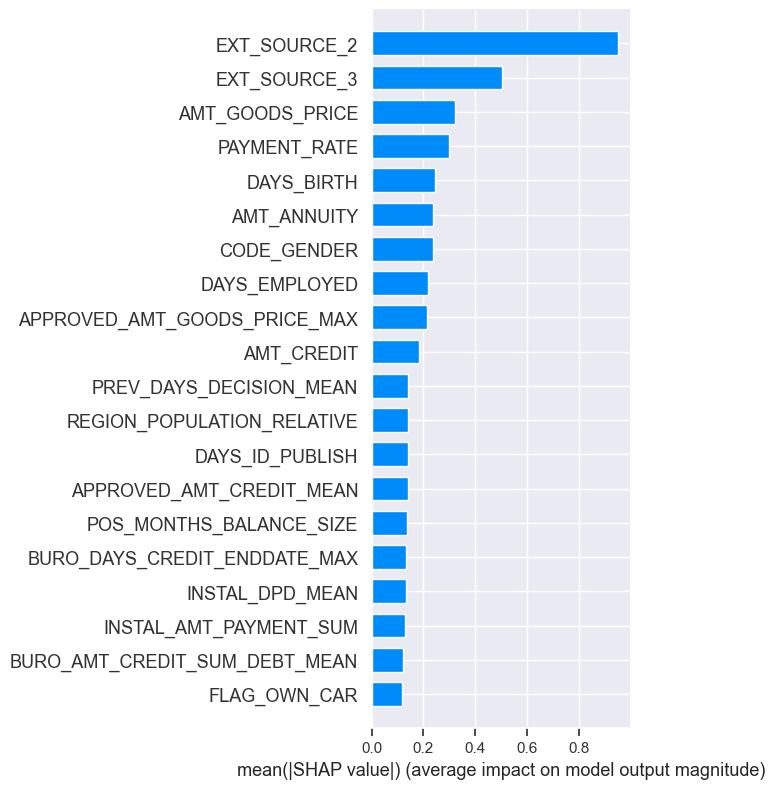

In [74]:
shap.summary_plot(shap_values[0], X_test, plot_type="bar")

### Explication sur le Force Plot  
https://coderzcolumn.com/tutorials/machine-learning/shap-explain-machine-learning-model-predictions-using-game-theoretic-approach#classification

Pour le client identifié n°22: probabilité pour rembourser son crédit: 41% et 59% de ne pas le rembourser.

In [89]:
i = 22

display(shap.force_plot(explainer.expected_value[0], shap_values[0][i], X.values[i], feature_names = X.columns, link='logit'))
display(shap.force_plot(explainer.expected_value[1], shap_values[1][i], X.values[i], feature_names = X.columns, link='logit'))

Pour le client identifié n°10: probabilité pour rembourser son crédit: 100% et 0% de ne pas le rembourser.

In [92]:
i = 10

display(shap.force_plot(explainer.expected_value[0], shap_values[0][i], X.values[i], feature_names = X.columns, link='logit'))
display(shap.force_plot(explainer.expected_value[1], shap_values[1][i], X.values[i], feature_names = X.columns, link='logit'))

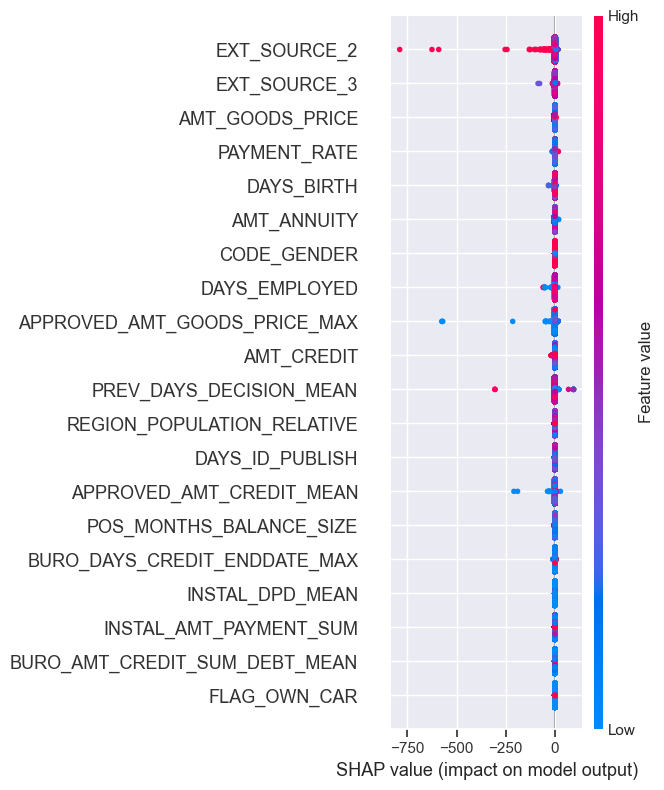

In [77]:
shap.summary_plot(shap_values[1], X_test.values, feature_names = X.columns)

___

# V. STREAMLIT

Afin de pouvoir afficher les données dans le dashboard, un échantillonage devait être réalisé. La taille du jeu de données était trop élevée pour s'afficher correctement dans des délais raisonnables. Deux dataframes seront réalisés. Un premier pour permettre **l'affichage** (display) et le second sera **normalisé** (modelling) pour être récupéré par le modèle. Les deux dataframes contiennent les mêmes clients (5000 clients)

### 1. DF DISPLAY 

In [93]:
# Import of dataframe

PATH="./P7_DATA/"
filename ="application_train.csv"
df_application = pd.read_csv(PATH+filename)

In [112]:
df_sample_streamlite = df_application.sample(n=100, random_state=4)
df_sample_streamlite.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
10246,111929,0,Cash loans,F,Y,N,1,157500.0,450000.0,16807.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
503,100580,0,Cash loans,F,N,Y,0,270000.0,528318.0,26973.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,9.0
36369,142116,0,Cash loans,M,Y,Y,1,157500.0,91647.0,8532.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
111030,228811,0,Cash loans,F,N,N,0,90000.0,225000.0,15219.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
69864,181044,0,Cash loans,M,Y,Y,2,225000.0,284256.0,28111.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [113]:
df_sample_streamlite['TARGET'].value_counts(normalize=True).round(2)
# Proportion sauvegardée par rapport aux données de base

0    0.92
1    0.08
Name: TARGET, dtype: float64

In [114]:
# Récupération des SK_ID_CURR pour récupérer les mêmes clients sur le dataframe du modelling
id_list = df_sample_streamlite['SK_ID_CURR'].tolist()
len(id_list)

100

In [115]:
# Features à garder
df_save = df_sample_streamlite[['SK_ID_CURR','TARGET','CODE_GENDER','DAYS_BIRTH', 'NAME_FAMILY_STATUS', 'CNT_CHILDREN',
                                'OCCUPATION_TYPE', 'AMT_INCOME_TOTAL',
                                'NAME_CONTRACT_TYPE','AMT_CREDIT','AMT_ANNUITY']]
display(df_save.head())
display(df_save.shape)

,SK_ID_CURR,TARGET,CODE_GENDER,DAYS_BIRTH,NAME_FAMILY_STATUS,CNT_CHILDREN,OCCUPATION_TYPE,AMT_INCOME_TOTAL,NAME_CONTRACT_TYPE,AMT_CREDIT,AMT_ANNUITY
10246,111929,0,F,-10559,Married,1,Secretaries,157500.0,Cash loans,450000.0,16807.5
503,100580,0,F,-19008,Married,0,Laborers,270000.0,Cash loans,528318.0,26973.0
36369,142116,0,M,-9720,Separated,1,Drivers,157500.0,Cash loans,91647.0,8532.0
111030,228811,0,F,-9867,Single / not married,0,Sales staff,90000.0,Cash loans,225000.0,15219.0
69864,181044,0,M,-16185,Married,2,Drivers,225000.0,Cash loans,284256.0,28111.5


(100, 11)

In [116]:
df_save.rename(columns = {  'SK_ID_CURR': 'ID DU CLIENT',
                            'CODE_GENDER': 'SEXE',
                            'CNT_CHILDREN': "NBRE D'ENFANTS",
                            'NAME_FAMILY_STATUS': 'STATUT MARITAL',
                            'AMT_INCOME_TOTAL': 'REVENU ANNUEL',
                            'DAYS_BIRTH': 'AGE',
                            'OCCUPATION_TYPE': 'EMPLOI',
                            'NAME_CONTRACT_TYPE': 'TYPE DE CONTRAT',
                            'AMT_CREDIT': 'MONTANT DU CREDIT',
                            'AMT_ANNUITY': 'ANNUITE DU CREDIT'
                         }, inplace = True)

df_save.head()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ID DU CLIENT,TARGET,SEXE,AGE,STATUT MARITAL,NBRE D'ENFANTS,EMPLOI,REVENU ANNUEL,TYPE DE CONTRAT,MONTANT DU CREDIT,ANNUITE DU CREDIT
10246,111929,0,F,-10559,Married,1,Secretaries,157500.0,Cash loans,450000.0,16807.5
503,100580,0,F,-19008,Married,0,Laborers,270000.0,Cash loans,528318.0,26973.0
36369,142116,0,M,-9720,Separated,1,Drivers,157500.0,Cash loans,91647.0,8532.0
111030,228811,0,F,-9867,Single / not married,0,Sales staff,90000.0,Cash loans,225000.0,15219.0
69864,181044,0,M,-16185,Married,2,Drivers,225000.0,Cash loans,284256.0,28111.5


In [117]:
# Conversion des jours en année

df_save['AGE_'] = df_save['AGE']/-365
df_save['AGE'] = df_save['AGE_'].astype(int)
df_save.drop(['AGE_'], axis=1, inplace = True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [118]:
df_save['RATIO ENDETTEMENT'] = (df_save['ANNUITE DU CREDIT']/df_save['REVENU ANNUEL']*100).round(2)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [125]:
df_save_temp = df_save.sort_values('ID DU CLIENT').head(15)
df_save_temp2 = df_save_temp.reset_index(drop = True)

In [129]:
df_save_temp2.head()

,ID DU CLIENT,TARGET,SEXE,AGE,STATUT MARITAL,NBRE D'ENFANTS,EMPLOI,REVENU ANNUEL,TYPE DE CONTRAT,MONTANT DU CREDIT,ANNUITE DU CREDIT,RATIO ENDETTEMENT
0,100580,0,F,52,Married,0,Laborers,270000.0,Cash loans,528318.0,26973.0,9.99
1,103925,0,F,25,Single / not married,0,Sales staff,67500.0,Cash loans,208512.0,16263.0,24.09
2,104103,0,M,50,Separated,1,Laborers,252000.0,Cash loans,787131.0,26145.0,10.38
3,104385,0,F,61,Widow,0,NaN,162000.0,Cash loans,211500.0,10795.5,6.66
4,107544,0,F,54,Separated,0,NaN,117000.0,Cash loans,330048.0,12573.0,10.75


**ENREGISTREMENT DF_SAMPLE_DISPLAY**

In [130]:
PATH = "dashboard/DATA_DASHBOARD/"
filename = "df_sample_display.csv"
df_save_temp2.to_csv(PATH + filename, index=False)

In [160]:
df_save_temp2[['ID DU CLIENT','SEXE','AGE', 'STATUT MARITAL', 
                            "NBRE D'ENFANTS",'EMPLOI', 'REVENU ANNUEL']].loc[df_save_temp2['TARGET'] == 1]

,ID DU CLIENT,SEXE,AGE,STATUT MARITAL,NBRE D'ENFANTS,EMPLOI,REVENU ANNUEL
9,125773,M,28,Single / not married,0,Core staff,157500.0
13,138212,F,56,Widow,0,Laborers,180000.0


___

**TEST AFFICHAGE DASHBOARD POUR UN CLIENT**

In [167]:
id = 125773

In [168]:
# Affichage données clients selon l'ID

df_sample_client = df_save[['ID DU CLIENT','SEXE','AGE', 'STATUT MARITAL', 
                            "NBRE D'ENFANTS",'EMPLOI', 'REVENU ANNUEL']].loc[df_save['ID DU CLIENT'] == id]

df_sample_client

,ID DU CLIENT,SEXE,AGE,STATUT MARITAL,NBRE D'ENFANTS,EMPLOI,REVENU ANNUEL
22132,125773,M,28,Single / not married,0,Core staff,157500.0


In [169]:
# Affichage données crédit du client selon l'ID

df_sample_credit = df_save[['TYPE DE CONTRAT','MONTANT DU CREDIT','ANNUITE DU CREDIT', 'RATIO ENDETTEMENT']].loc[df_save['ID DU CLIENT'] == id]

df_sample_credit

,TYPE DE CONTRAT,MONTANT DU CREDIT,ANNUITE DU CREDIT,RATIO ENDETTEMENT
22132,Cash loans,1042560.0,34456.5,21.88


___

### 2. DF MODELLING

In [134]:
# Import of dataframe merge (kernel kagggle), avec id, prêt pour le modeling:
# il est imputé par médiane et colonnes Nan>20% sont supprimées

PATH="./P7_DATA/cleaned/"
filename ="df.csv"
df_merge = pd.read_csv(PATH+filename)
df_merge.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,100002.0,1.0,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19.0
1,100003.0,0.0,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25.0
2,100004.0,0.0,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3.0
3,100006.0,0.0,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,...,62947.088438,1007153.415,2482.920,691786.890,62947.088438,1007153.415,-12.0,-271.625000,-4346.0,16.0
4,100007.0,0.0,0.0,0.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,...,12666.444545,835985.340,0.180,22678.785,12214.060227,806127.975,-14.0,-1032.242424,-68128.0,66.0


In [158]:
new_df = df_merge.loc[df_merge['SK_ID_CURR'].isin(id_list)] # on récupère les mêmes clients que dans le df_display
display(new_df.head())
display(new_df.shape)

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
503,100580.0,0.0,1.0,0.0,0.0,0.0,270000.0,528318.0,26973.0,441000.0,...,42543.422437,3403473.795,4952.430,827958.600,53455.975313,4276478.025,-40.0,-852.037500,-68163.0,80.0
3358,103925.0,0.0,1.0,0.0,1.0,0.0,67500.0,208512.0,16263.0,180000.0,...,18121.938750,72487.755,7083.045,51238.620,18121.938750,72487.755,-447.0,-503.750000,-2015.0,4.0
3514,104103.0,0.0,0.0,0.0,0.0,1.0,252000.0,787131.0,26145.0,679500.0,...,15557.542500,93345.255,4070.565,72992.430,15557.542500,93345.255,-934.0,-1059.833333,-6359.0,6.0
3756,104385.0,0.0,1.0,1.0,0.0,0.0,162000.0,211500.0,10795.5,211500.0,...,30517.425000,488278.800,13742.235,171758.385,32563.518750,521016.300,-29.0,-243.875000,-3902.0,16.0
6468,107544.0,0.0,1.0,0.0,0.0,0.0,117000.0,330048.0,12573.0,216000.0,...,23056.161848,1060583.445,6721.830,131493.690,23056.161848,1060583.445,-23.0,-1387.913043,-63844.0,46.0


(100, 508)

In [138]:
temp = new_df.reset_index(drop = True)
temp.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,100580.0,0.0,1.0,0.0,0.0,0.0,270000.0,528318.0,26973.0,441000.0,...,42543.422437,3403473.795,4952.430,827958.600,53455.975313,4276478.025,-40.0,-852.037500,-68163.0,80.0
1,103925.0,0.0,1.0,0.0,1.0,0.0,67500.0,208512.0,16263.0,180000.0,...,18121.938750,72487.755,7083.045,51238.620,18121.938750,72487.755,-447.0,-503.750000,-2015.0,4.0
2,104103.0,0.0,0.0,0.0,0.0,1.0,252000.0,787131.0,26145.0,679500.0,...,15557.542500,93345.255,4070.565,72992.430,15557.542500,93345.255,-934.0,-1059.833333,-6359.0,6.0
3,104385.0,0.0,1.0,1.0,0.0,0.0,162000.0,211500.0,10795.5,211500.0,...,30517.425000,488278.800,13742.235,171758.385,32563.518750,521016.300,-29.0,-243.875000,-3902.0,16.0
4,107544.0,0.0,1.0,0.0,0.0,0.0,117000.0,330048.0,12573.0,216000.0,...,23056.161848,1060583.445,6721.830,131493.690,23056.161848,1060583.445,-23.0,-1387.913043,-63844.0,46.0


In [139]:
# Featuring pour scaler les colonnes autres que SK_ID et TARGET
ignore_features = ['SK_ID_CURR', 'TARGET']
relevant_features = [col for col in temp.columns if col not in ignore_features]

In [140]:
scaler = MinMaxScaler(feature_range = (0, 1))

In [141]:
scalerdf = scaler.fit_transform(temp[relevant_features])

In [142]:
new_test = pd.DataFrame(scalerdf, columns=relevant_features)
new_test.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,1.0,0.0,0.0,0.000000,0.416667,0.228397,0.311494,0.215584,0.084990,0.323637,...,0.346678,1.000000,0.095818,0.644215,0.250167,1.000000,0.983914,0.663900,0.611021,0.793814
1,1.0,0.0,1.0,0.000000,0.041667,0.069890,0.149908,0.064935,0.243683,0.920070,...,0.133438,0.012232,0.137043,0.037787,0.076415,0.010377,0.802055,0.821563,0.992797,0.010309
2,0.0,0.0,0.0,0.333333,0.383333,0.356673,0.299002,0.353247,0.124537,0.357387,...,0.111046,0.018417,0.078755,0.054771,0.063805,0.015287,0.584450,0.569835,0.967726,0.030928
3,1.0,1.0,0.0,0.000000,0.216667,0.071371,0.067418,0.083117,0.413845,0.120766,...,0.241671,0.135530,0.265889,0.131883,0.147430,0.115961,0.988829,0.939203,0.981906,0.134021
4,1.0,0.0,0.0,0.000000,0.133333,0.130128,0.094236,0.085714,0.122922,0.278638,...,0.176522,0.305241,0.130054,0.100446,0.100679,0.242976,0.991510,0.421320,0.635949,0.443299


In [143]:
sk = temp[['SK_ID_CURR']].astype(int)
sk.head()

,SK_ID_CURR
0,100580
1,103925
2,104103
3,104385
4,107544


In [144]:
# Fusion du df scalé et des ID des clients
df_sample_modelling = sk.join(new_test)
df_sample_modelling.head()

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,100580,1.0,0.0,0.0,0.000000,0.416667,0.228397,0.311494,0.215584,0.084990,...,0.346678,1.000000,0.095818,0.644215,0.250167,1.000000,0.983914,0.663900,0.611021,0.793814
1,103925,1.0,0.0,1.0,0.000000,0.041667,0.069890,0.149908,0.064935,0.243683,...,0.133438,0.012232,0.137043,0.037787,0.076415,0.010377,0.802055,0.821563,0.992797,0.010309
2,104103,0.0,0.0,0.0,0.333333,0.383333,0.356673,0.299002,0.353247,0.124537,...,0.111046,0.018417,0.078755,0.054771,0.063805,0.015287,0.584450,0.569835,0.967726,0.030928
3,104385,1.0,1.0,0.0,0.000000,0.216667,0.071371,0.067418,0.083117,0.413845,...,0.241671,0.135530,0.265889,0.131883,0.147430,0.115961,0.988829,0.939203,0.981906,0.134021
4,107544,1.0,0.0,0.0,0.000000,0.133333,0.130128,0.094236,0.085714,0.122922,...,0.176522,0.305241,0.130054,0.100446,0.100679,0.242976,0.991510,0.421320,0.635949,0.443299


**TEST AFFICHAGE SCORING POUR UN CLIENT**

In [172]:
id = 142116

In [173]:
ligne_client = df_sample_modelling[df_sample_modelling['SK_ID_CURR']==id]
ligne_client

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
14,142116,0.0,1.0,0.0,0.333333,0.208333,0.011968,0.033268,0.005195,0.335355,...,0.019253,0.047584,0.001477,0.006636,0.010642,0.035771,0.996425,0.970644,0.966173,0.360825


In [174]:
ligne_ok = ligne_client.drop('SK_ID_CURR', axis=1)
ligne_ok

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
14,0.0,1.0,0.0,0.333333,0.208333,0.011968,0.033268,0.005195,0.335355,0.900926,...,0.019253,0.047584,0.001477,0.006636,0.010642,0.035771,0.996425,0.970644,0.966173,0.360825


### MODEL

In [148]:
# define model
lgbm = lgb.LGBMClassifier(**grid_lgmc_smote.best_params_, random_state=22)

In [149]:
lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: model__learning_rate
[LightGBM] [Warning] Unknown parameter: model__n_estimators


LGBMClassifier(model__learning_rate=0.5, model__n_estimators=1000,
               random_state=22)

In [150]:
lgbm.score(X_test, y_test)

0.9209131410360639

In [151]:
# sérialiser la pipeline pour le dashboard
joblib.dump(lgbm, 'lgbm.joblib')

['lgbm.joblib']

In [175]:
proba = lgbm.predict_proba(ligne_ok)
proba

array([[0.68983205, 0.31016795]])

In [202]:
# prédiction du 0, puis transformé en float pour être lu dans la jauge
proba1 = round(float(lgbm.predict_proba(ligne_ok)[:,0]),2)
proba1

0.69

In [199]:
df_temp = pd.DataFrame(proba,columns = ['remboursé', 'défaut'])
df_temp

,remboursé,défaut
0,0.689832,0.310168


**ENREGISTREMENT DF_SAMPLE_MODELLING**

In [155]:
PATH = "dashboard/DATA_DASHBOARD/"
filename = "df_sample_modelling.csv"
df_sample_modelling.to_csv(PATH + filename, index=False)